<a href="https://colab.research.google.com/github/vicentbas/ia3_uv/blob/main/ecg_full_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---
# Trabajo evaluación bloque 2: Clasificador de electrocardiogramas mediante LSTM

#<strong><center> ECG analyzer </strong>

El objetivo del siguiente proyecto es crear un clasificador de electrocardiogramas, capaz de diferencias entre estudios patológicos y estudios normales. Como entrada al proyecto se utilzan ficheros XML exportados desde el sistema Philips IntelliSpace ECG B.00.02 en formato XML FDA para electrocardiografos de 12 derivaciones.

In [1]:
from xml.dom import minidom
from os import listdir
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Input, Concatenate, GlobalMaxPooling1D, BatchNormalization, Activation, TimeDistributed, Conv1D, MaxPooling1D, Dropout, LeakyReLU
from keras.optimizers import Adam
from tensorflow import keras

import glob
import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(7)

In [2]:
def extract_data_estruct4(dir):
  ecg_studies = pd.DataFrame({'id':[],'lead':[],'mV':[], 'severity':[]})
  for ids, file in enumerate(glob.glob(dir+"*.fda.xml")):
    ecg_xml_diag = minidom.parse(file.split(".")[0]+"."+file.split(".")[3]) 
    ecg_xml_severity = ecg_xml_diag.getElementsByTagName('severity')
    ecg_severity = ecg_xml_severity[0].firstChild.data
    ecg_xml = minidom.parse(file) 
    ecg_sequence = ecg_xml.getElementsByTagName('sequence')
    for sequence in ecg_sequence:
      code = sequence.getElementsByTagName("code")[0]
      if "MDC_ECG_LEAD" in code.getAttribute("code"):
        lead_name = code.getAttribute("code")
        scale = sequence.getElementsByTagName("scale")[0]
        if scale.getAttribute("value") == "5.0":
          digits = sequence.getElementsByTagName('digits')[0]
          lead_value = digits.firstChild.data
          ecg_leads_mv = lead_value.replace("\n","")
          ecg_leads_mv = ecg_leads_mv.replace("\t","")
          ecg_leads_mv = ecg_leads_mv.replace("  ","")
          ecg_leads_mv = ecg_leads_mv.replace("  ","")
          ecg_leads_mv = ecg_leads_mv.split(" ")[:-1]
          lead_array = np.array(ecg_leads_mv,dtype=float)
          ecg_studies = ecg_studies.append(pd.DataFrame({'id':ids, 'lead':lead_name,'mV':[lead_array], 'severity':int(ecg_severity)}), ignore_index=True)
  return ecg_studies

In [3]:
ecg_dataframe = extract_data_estruct4('/content/ecg/')

In [4]:
ecg_dataframe

,id,lead,mV,severity
0,0.0,MDC_ECG_LEAD_I,"[2.0, 1.0, 2.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, ...",1.0
1,0.0,MDC_ECG_LEAD_II,"[-16.0, -15.0, -15.0, -15.0, -19.0, -17.0, -17...",1.0
2,0.0,MDC_ECG_LEAD_III,"[-20.0, -19.0, -17.0, -17.0, -20.0, -18.0, -20...",1.0
3,0.0,MDC_ECG_LEAD_AVR,"[7.0, 6.0, 7.0, 6.0, 8.0, 7.0, 8.0, 6.0, 7.0, ...",1.0
4,0.0,MDC_ECG_LEAD_AVL,"[11.0, 10.0, 10.0, 10.0, 12.0, 11.0, 12.0, 10....",1.0
...,...,...,...,...
979,81.0,MDC_ECG_LEAD_V2,"[10.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0...",1.0
980,81.0,MDC_ECG_LEAD_V3,"[16.0, 14.0, 16.0, 15.0, 16.0, 20.0, 18.0, 19....",1.0
981,81.0,MDC_ECG_LEAD_V4,"[4.0, 1.0, 5.0, 5.0, 5.0, 5.0, 7.0, 5.0, 4.0, ...",1.0
982,81.0,MDC_ECG_LEAD_V5,"[0.0, 4.0, 5.0, 4.0, 6.0, 8.0, 4.0, 3.0, 7.0, ...",1.0


# Understanding data structure
Anidación de dataframes, con un primer nivel para estudios y un segundo nivel para cada una de las derivaciones.

**Severity:**

0 = estudio normal

1 = estudio fuera de lo normal

In [5]:
print("Numero de estudios anormales: "+str(ecg_dataframe[ecg_dataframe['severity']==1].count()[0]/12))

Numero de estudios anormales: 66.0


In [6]:
print("Numero de estudios normales: "+str(ecg_dataframe[ecg_dataframe['severity']==0].count()[0]/12))

Numero de estudios normales: 16.0


# Ploting sample leads

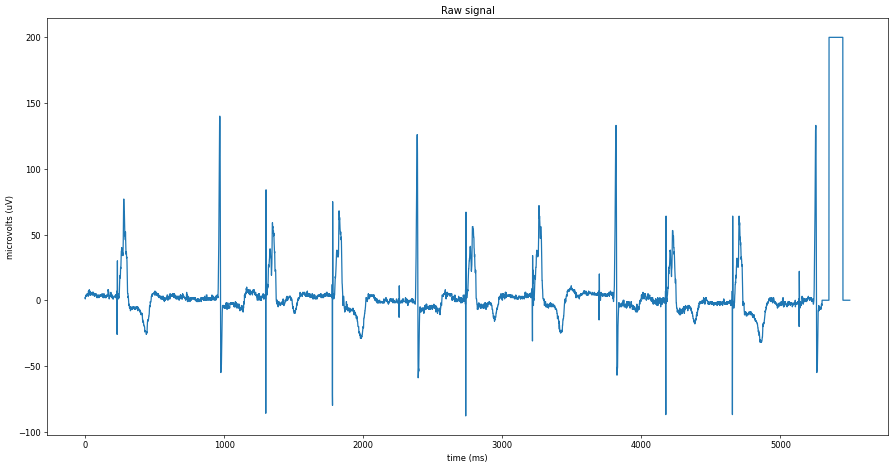

In [7]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(ecg_dataframe[ecg_dataframe['lead']=='MDC_ECG_LEAD_I'].mV[0])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (uV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

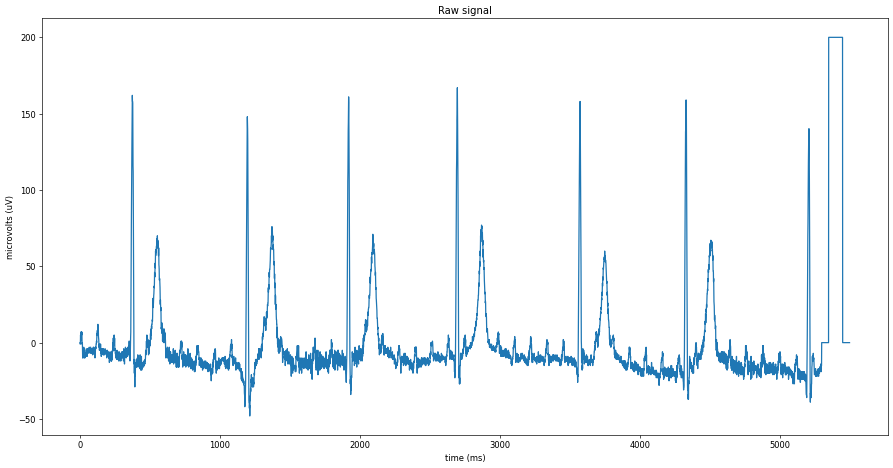

In [8]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(ecg_dataframe[ecg_dataframe['lead']=='MDC_ECG_LEAD_I'].mV[12])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (uV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

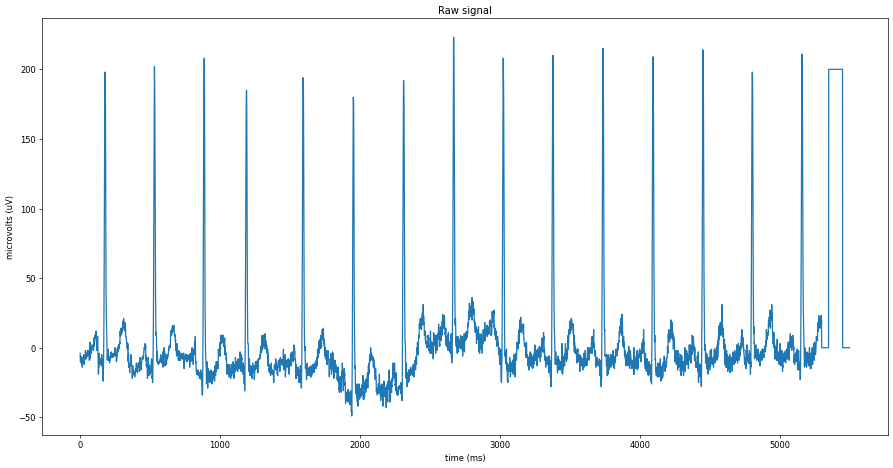

In [9]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(ecg_dataframe[ecg_dataframe['lead']=='MDC_ECG_LEAD_I'].mV[24])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (uV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

# Data group by lead name

In [10]:
lead = pd.DataFrame({})
lead_sev = pd.DataFrame({})

In [11]:
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
             'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:

  lead[lead_name] = [np.array(ecg_dataframe[ecg_dataframe['lead']==lead_name].mV.tolist())]
  lead_sev[lead_name] = [np.array(ecg_dataframe[ecg_dataframe['lead']==lead_name].severity.tolist())]

# Data normalization

In [12]:
lead['MDC_ECG_LEAD_V2'][0]

array([[  7.,   5.,   5., ...,   0.,   0.,   0.],
       [  1.,   0.,   1., ...,   0.,   0.,   0.],
       [-31., -28., -28., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [-54., -42., -43., ...,   0.,   0.,   0.],
       [ 10.,   9.,  10., ...,   0.,   0.,   0.]])

In [13]:
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
             'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  scaler = preprocessing.MinMaxScaler()
  lead[lead_name][0] = scaler.fit_transform(lead[lead_name][0])

In [14]:
lead['MDC_ECG_LEAD_V2'][0]

array([[0.97580221, 0.97318612, 0.96755625, ..., 0.        , 0.        ,
        0.        ],
       [0.97264598, 0.97055731, 0.96546311, ..., 0.        , 0.        ,
        0.        ],
       [0.95581273, 0.95583596, 0.95028781, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.97211994, 0.97055731, 0.96493982, ..., 0.        , 0.        ,
        0.        ],
       [0.94371383, 0.94847529, 0.94243851, ..., 0.        , 0.        ,
        0.        ],
       [0.97738033, 0.97528917, 0.97017268, ..., 0.        , 0.        ,
        0.        ]])

In [15]:
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
             'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  lead[lead_name][0] = lead[lead_name][0].reshape(lead[lead_name][0].shape[0],5500,1)
  lead_sev[lead_name][0] = lead_sev[lead_name][0].reshape(lead_sev[lead_name][0].shape[0],1)

# RNN LSTM building

In [16]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

history = pd.DataFrame({})

for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
             'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  X = lead[lead_name][0]
  y = lead_sev[lead_name][0]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  input = Input((5500,1))
  ecg_model = Conv1D(64,kernel_size=20)(input)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(128,kernel_size=16)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=8)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(512,kernel_size=4)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=8)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = LSTM(128,  go_backwards=True, return_sequences=True)(ecg_model)
  ecg_model = Dense(64, activation='relu')(ecg_model)
  o  = Dense(1, activation='sigmoid')(ecg_model)

  model = Model(inputs = input, outputs = o)
  opt = Adam(lr=0.0000001)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
  history[lead_name] = [model.fit(X_train,y_train, epochs=400, verbose=0, validation_data=(X_test,y_test))]


Found GPU at: /device:GPU:0


MDC_ECG_LEAD_I


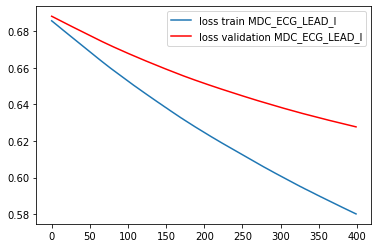

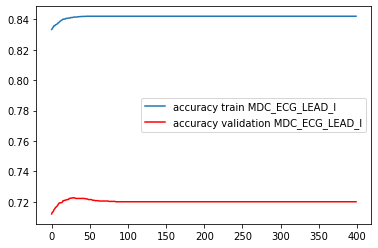

MDC_ECG_LEAD_II


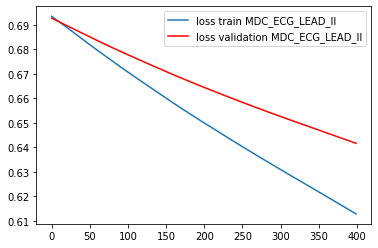

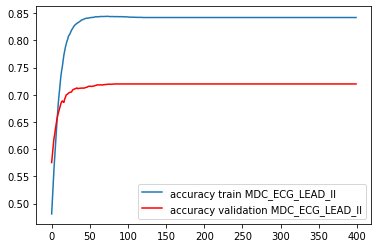

MDC_ECG_LEAD_III


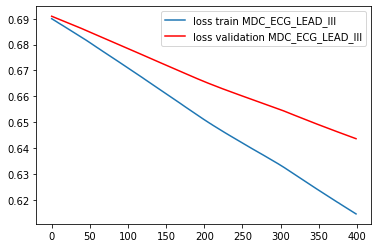

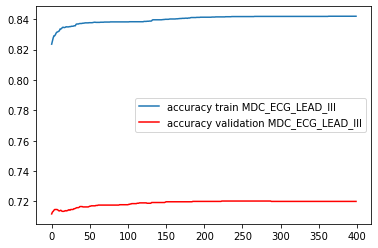

MDC_ECG_LEAD_AVR


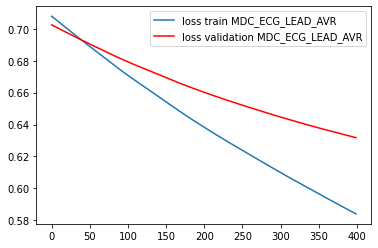

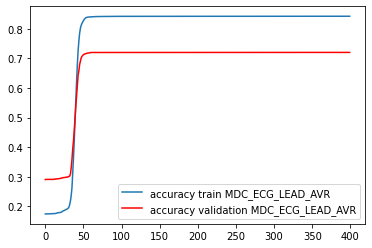

MDC_ECG_LEAD_AVL


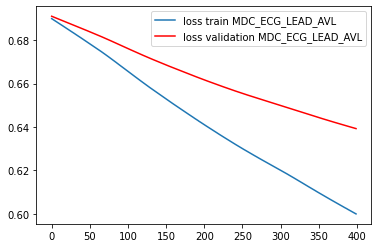

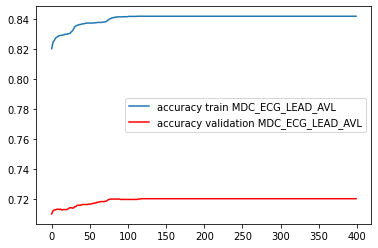

MDC_ECG_LEAD_AVF


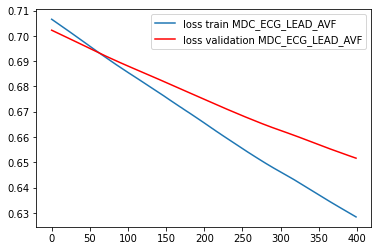

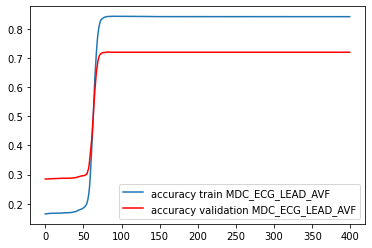

MDC_ECG_LEAD_V1


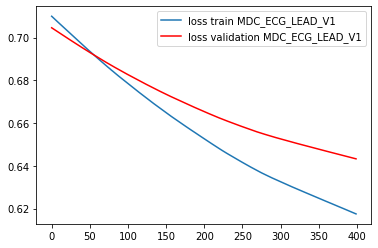

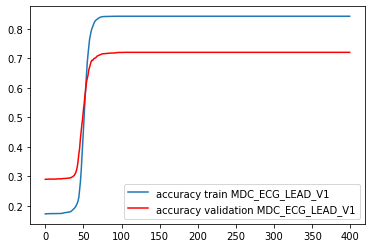

MDC_ECG_LEAD_V2


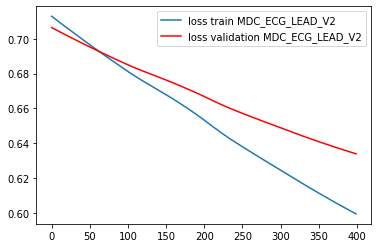

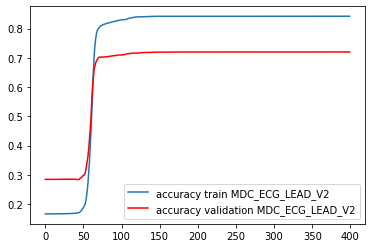

MDC_ECG_LEAD_V3


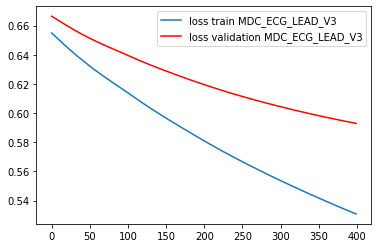

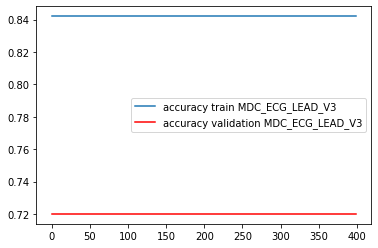

MDC_ECG_LEAD_V4


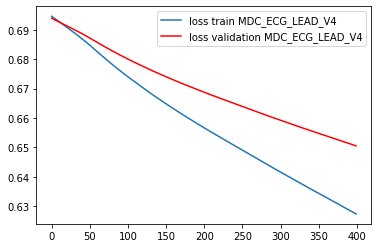

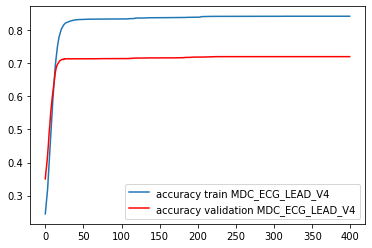

MDC_ECG_LEAD_V5


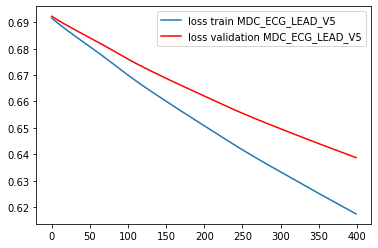

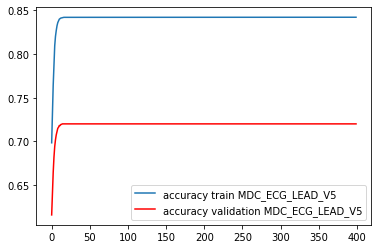

MDC_ECG_LEAD_V6


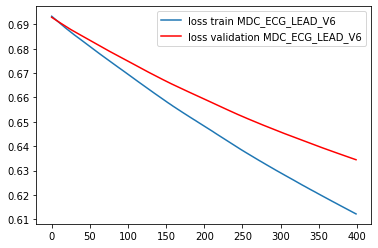

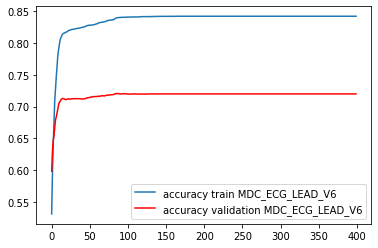

In [17]:
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
            'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  print(lead_name)

  import matplotlib.pyplot as plt
  %matplotlib inline
  plt.figure
  plt.plot(history[lead_name][0].history['loss'],label='loss train %s' % lead_name)
  plt.plot(history[lead_name][0].history['val_loss'],'r',label='loss validation %s' % lead_name)
  plt.legend()
  plt.show()

  import matplotlib.pyplot as plt
  %matplotlib inline
  plt.figure
  plt.plot(history[lead_name][0].history['accuracy'],label='accuracy train %s' % lead_name)
  plt.plot(history[lead_name][0].history['val_accuracy'],'r',label='accuracy validation %s' % lead_name)
  plt.legend()
  plt.show()

In [18]:
#print(model.summary())

#from IPython.display import SVG, display, clear_output
#from keras.utils.vis_utils import model_to_dot

#display(SVG(model_to_dot(model, show_shapes=True, dpi=50).create(prog='dot', format='svg')))